# Sequential multi-agent pattern

Many complex tasks naturally decompose into sequential stages where each stage builds on the work of the previous one. Like an assembly line where each station adds something specific before passing the work to the next station, AI agents can form processing chains where specialized agents work in sequence.

The sequential multi-agent pattern is a workflow approach where multiple independent agents work in a fixed chain, with each agent performing a specific transformation or processing step before passing its output to the next agent. Each agent is independent with its own state and reasoning loop. The output of agent N becomes the input for agent N+1, creating a data processing pipeline. This pattern is particularly valuable for:
- Multi-stage transformations (e.g., data collection → processing → analysis → presentation).
- Tasks with natural sequential dependencies.
- Workflows where each stage requires different expertise.
- Situations where you want clear separation of concerns.

In this notebook, we will implement a sequential multi-agent system for processing a research query:
1. **Data collector agent** - Independent agent that gathers raw information from sources.
2. **Data processor agent** - Independent agent that cleans and structures the collected data.
3. **Insight generator agent** - Independent agent that analyzes the processed data to extract insights.
4. **Report writer agent** - Independent agent that formats insights into a final user-facing report.
5. **Pipeline coordinator** - Orchestrates the sequential execution of all agents.

This demonstrates how multiple independent agents can form an effective processing pipeline where each stage adds specific value before handing off to the next stage.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia
import json

### Initialize the language model

In a sequential pipeline, each agent performs a specific type of transformation. We use the same base model for all agents, differentiating them through their system prompts and specific capabilities.

In [2]:
# Initialize the OpenAI language model
# Using temperature=0 for consistent pipeline behavior
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.0)

We use `temperature=0.0` to ensure deterministic outputs at each stage of the pipeline. This consistency is important when stages build on each other.

### Define tools

The data collector agent needs access to external information sources. We provide tools that enable information gathering.

#### Wikipedia search tool

In [3]:
@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for the query and return a brief summary of the top result."""
    try:
        # First, try to find matching pages using search
        search_results = wikipedia.search(query, results=3)

        if not search_results:
            return f"No Wikipedia pages found for query: {query}"

        # Try to get summary from the top search result
        try:
            summary = wikipedia.summary(search_results[0], sentences=5)
            return f"Wikipedia article: '{search_results[0]}'\n\n{summary}"
        except wikipedia.exceptions.DisambiguationError as e:
            # If disambiguation page, try the first option
            if e.options:
                summary = wikipedia.summary(e.options[0], sentences=5)
                return f"Wikipedia article: '{e.options[0]}' (from disambiguation)\n\n{summary}"
            return f"Disambiguation page found. Options: {', '.join(e.options[:5])}"
        except Exception as e:
            # Try the next search result
            if len(search_results) > 1:
                try:
                    summary = wikipedia.summary(search_results[1], sentences=5)
                    return f"Wikipedia article: '{search_results[1]}'\n\n{summary}"
                except:
                    pass
            return f"Error retrieving page: {e}"
    except Exception as e:
        # Return error if the query fails completely
        return f"Error: {e}"

The Wikipedia tool enables the data collector to gather information. In a real system, we might have multiple collection tools.

#### Bind tools to model

In [4]:
# Collect tools and create a registry
tools = [wiki_search]
tools_by_name = {tool.name: tool for tool in tools}

# Create a tool-enabled LLM for the data collector agent
llm_with_tools = llm.bind_tools(tools)

We create a tool-enabled version of the LLM for agents that need external data access.

### Build independent pipeline agents

Now we create separate, independent agents for each stage of the pipeline. Each agent is a complete, self-contained system with its own state and graph.

#### Stage 1: Data collector agent
The data collector agent is an independent agent specialized in gathering raw information.

In [5]:
# Define state for the data collector agent
class CollectorAgentState(TypedDict):
    """State for the independent Data Collector Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    query: str  # The research query
    raw_data: str  # The collected raw data

def collector_agent_work(state: CollectorAgentState):
    """Data collector agent: Gather raw information from sources."""
    
    # System prompt defines this agent's specialization
    system_prompt = SystemMessage(
        content="""You are an independent Data Collector Agent.
        
        Your expertise: Gathering relevant raw information to answer questions.
        Use the wiki_search tool to collect facts and data.

        IMPORTANT: When using wiki_search, use concise, Wikipedia-friendly search terms:
        - For broad topics, use the main topic name (e.g., "Industrial Revolution" not "What are the innovations of the Industrial Revolution")
        - For specific concepts, use the concept name (e.g., "Steam Engine" not "How did steam engines work")
        - If you need multiple perspectives, make multiple wiki_search calls with different focused queries
        
        Focus on breadth - collect all potentially relevant information.
        Don't analyze or filter.
        """
    )
    
    # Get the query
    query = state["query"]
    
    # Create collection task
    task_message = HumanMessage(content=f"Collect information about: {query}")
    
    # Execute collection with tool access
    response = llm_with_tools.invoke([system_prompt, task_message])
    
    # Process tool calls
    raw_data_text = response.content if response.content else ""
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            # Execute the tool
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."
            
            # Append tool results
            raw_data_text += f"\n\nCollected Data:\n{result}"
    
    return {
        "messages": [AIMessage(content=raw_data_text)],
        "raw_data": raw_data_text
    }

# Build the Data Collector Agent graph
collector_graph = StateGraph(CollectorAgentState)
collector_graph.add_node("collect", collector_agent_work)
collector_graph.add_edge(START, "collect")
collector_graph.add_edge("collect", END)

# Compile the Data Collector Agent as an independent agent
collector_agent = collector_graph.compile()

The data collector agent is now a complete, independent agent that gathers raw information.

#### Stage 2: Data processor agent
The data processor agent is an independent agent specialized in cleaning and structuring data.

In [6]:
# Define state for the data processor agent
class ProcessorAgentState(TypedDict):
    """State for the independent Data Processor Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_data: str  # Raw data from collector
    processed_data: str  # Cleaned and structured data

def processor_agent_work(state: ProcessorAgentState):
    """Data processor agent: Clean and structure the raw data."""
    
    # System prompt defines this agent's specialization
    system_prompt = SystemMessage(
        content="""You are an independent Data Processor Agent.
        
        Your expertise: Processing and structuring raw data.
        - Remove irrelevant information
        - Organize data into logical categories
        - Structure it for easy analysis
        - Identify and highlight key facts
        
        Output should be clean, organized, and ready for analysis.
        """
    )
    
    # Get the raw data
    raw_data = state["raw_data"]
    
    # Create processing task
    task_message = HumanMessage(
        content=f"""Process and structure this raw data:
        
        {raw_data}"""
    )
    
    # Execute processing
    response = llm.invoke([system_prompt, task_message])
    
    processed_text = response.content
    
    return {
        "messages": [AIMessage(content=processed_text)],
        "processed_data": processed_text
    }

# Build the Data Processor Agent graph
processor_graph = StateGraph(ProcessorAgentState)
processor_graph.add_node("process", processor_agent_work)
processor_graph.add_edge(START, "process")
processor_graph.add_edge("process", END)

# Compile the Data Processor Agent as an independent agent
processor_agent = processor_graph.compile()

The data processor agent is now a complete, independent agent that cleans and structures data.

#### Stage 3: Insight generator agent
The insight generator agent is an independent agent specialized in extracting insights from processed data.

In [7]:
# Define state for the insight generator agent
class InsightAgentState(TypedDict):
    """State for the independent Insight Generator Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    processed_data: str  # Processed data from processor
    insights: str  # Extracted insights

def insight_agent_work(state: InsightAgentState):
    """Insight generator agent: Extract insights from processed data."""
    
    # System prompt defines this agent's specialization
    system_prompt = SystemMessage(
        content="""You are an independent Insight Generator Agent.
        
        Your expertise: Analyzing data and extracting meaningful insights.
        - Identify patterns and trends
        - Draw connections between facts
        - Generate actionable insights
        - Highlight what's most important
        
        Output should be analytical and insight-focused.
        """
    )
    
    # Get the processed data
    processed_data = state["processed_data"]
    
    # Create analysis task
    task_message = HumanMessage(
        content=f"""Extract key insights from this processed data:
        
        {processed_data}"""
    )
    
    # Execute analysis
    response = llm.invoke([system_prompt, task_message])
    
    insights_text = response.content
    
    return {
        "messages": [AIMessage(content=insights_text)],
        "insights": insights_text
    }

# Build the Insight Generator Agent graph
insight_graph = StateGraph(InsightAgentState)
insight_graph.add_node("analyze", insight_agent_work)
insight_graph.add_edge(START, "analyze")
insight_graph.add_edge("analyze", END)

# Compile the Insight Generator Agent as an independent agent
insight_agent = insight_graph.compile()

The insight generator agent is now a complete, independent agent that extracts analytical insights.

#### Stage 4: Report writer agent
The report writer agent is an independent agent specialized in creating polished final reports.

In [8]:
# Define state for the Report writer agent
class WriterAgentState(TypedDict):
    """State for the independent Report Writer Agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    insights: str  # Insights from insight generator
    final_report: str  # The final polished report

def writer_agent_work(state: WriterAgentState):
    """Report writer agent: Create polished final report."""
    
    # System prompt defines this agent's specialization
    system_prompt = SystemMessage(
        content="""You are an independent Report Writer Agent.
        
        Your expertise: Creating comprehensive, well-written final reports.
        - Write clearly and engagingly for the end user
        - Organize the report with a logical structure
        - Make it complete and user-friendly
        
        This is the final output the user will see - make it excellent.
        """
    )
    
    # Get the insights
    insights = state["insights"]
    
    # Create writing task
    task_message = HumanMessage(
        content=f"""Create a comprehensive final report from these insights:
        
        {insights}"""
    )
    
    # Execute writing
    response = llm.invoke([system_prompt, task_message])
    
    final_text = response.content
    
    return {
        "messages": [AIMessage(content=final_text)],
        "final_report": final_text
    }

# Build the Report Writer Agent graph
writer_graph = StateGraph(WriterAgentState)
writer_graph.add_node("write", writer_agent_work)
writer_graph.add_edge(START, "write")
writer_graph.add_edge("write", END)

# Compile the Report Writer Agent as an independent agent
writer_agent = writer_graph.compile()

The report writer agent is now a complete, independent agent that creates polished final reports.

### Build the pipeline coordinator
Now we create the pipeline coordinator that orchestrates the sequential execution of all agents, passing outputs from one to the next.

In [9]:
# Define state for the pipeline coordinator
class PipelineCoordinatorState(TypedDict):
    """State for the Pipeline Coordinator that orchestrates sequential agents."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str  # The original user question
    data_collection_output: str  # Output from Data Collector
    data_processing_output: str  # Output from Data Processor
    insight_generation_output: str  # Output from Insight Generator
    report_writing_output: str  # Output from Report Writer

def coordinate_data_collection(state: PipelineCoordinatorState):
    """Coordinate Stage 1: Data Collection."""
    
    # Invoke the independent data collector agent
    result = collector_agent.invoke({
        "messages": [],
        "query": state["user_question"],
        "raw_data": ""
    })
    
    return {
        "messages": [AIMessage(content="[Data Collection] Complete")],
        "data_collection_output": result["raw_data"]
    }

def coordinate_data_processing(state: PipelineCoordinatorState):
    """Coordinate Stage 2: Data Processing."""
    
    # Invoke the independent data processor agent with stage 1 output
    result = processor_agent.invoke({
        "messages": [],
        "raw_data": state["data_collection_output"],
        "processed_data": ""
    })
    
    return {
        "messages": [AIMessage(content="[Data Processing] Complete")],
        "data_processing_output": result["processed_data"]
    }

def coordinate_insight_generation(state: PipelineCoordinatorState):
    """Coordinate Stage 3: Insight Generation."""
    
    # Invoke the independent insight generator agent with stage 2 output
    result = insight_agent.invoke({
        "messages": [],
        "processed_data": state["data_processing_output"],
        "insights": ""
    })
    
    return {
        "messages": [AIMessage(content="[Insight Generation] Complete")],
        "insight_generation_output": result["insights"]
    }

def coordinate_report_writing(state: PipelineCoordinatorState):
    """Coordinate Stage 4: Report Writing."""
    
    # Invoke the independent report writer agent with stage 3 output
    result = writer_agent.invoke({
        "messages": [],
        "insights": state["insight_generation_output"],
        "final_report": ""
    })
    
    return {
        "messages": [AIMessage(content="[Report Writing] Complete")],
        "report_writing_output": result["final_report"]
    }

# Build the pipeline coordinator graph
coordinator_graph = StateGraph(PipelineCoordinatorState)

# Add nodes for coordinating each stage
coordinator_graph.add_node("data_collection", coordinate_data_collection)
coordinator_graph.add_node("data_processing", coordinate_data_processing)
coordinator_graph.add_node("insight_generation", coordinate_insight_generation)
coordinator_graph.add_node("report_writing", coordinate_report_writing)

# Define the sequential pipeline flow
coordinator_graph.add_edge(START, "data_collection")
coordinator_graph.add_edge("data_collection", "data_processing")
coordinator_graph.add_edge("data_processing", "insight_generation")
coordinator_graph.add_edge("insight_generation", "report_writing")
coordinator_graph.add_edge("report_writing", END)

# Compile the pipeline coordinator
pipeline_coordinator = coordinator_graph.compile()

The pipeline coordinator orchestrates the sequential execution of all four independent agents, passing outputs from one stage to the next.

### Visualize the pipeline

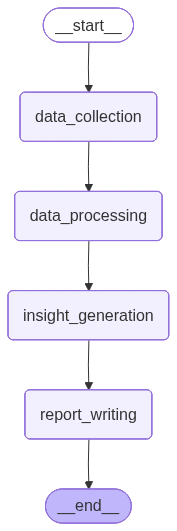

In [10]:
# Visualize the pipeline coordinator's workflow
display(
    Image(
        pipeline_coordinator.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run an example
Let's see the sequential multi-agent pattern in action with a question that benefits from systematic processing through the pipeline.

In [11]:
# Example: A question that benefits from sequential processing
user_question = "What are the key technological innovations of the Industrial Revolution?"

# Initialize the Pipeline Coordinator
initial_state = PipelineCoordinatorState(
    messages=[HumanMessage(content=user_question)],
    user_question=user_question,
    data_collection_output="",
    data_processing_output="",
    insight_generation_output="",
    report_writing_output=""
)

# Run the sequential multi-agent pipeline
print("=== Sequential Multi-Agent Pattern Execution ===")
print(f"\nUser Question: {user_question}\n")
print("Processing through 4-stage pipeline...\n")

result = pipeline_coordinator.invoke(initial_state)

# Display the results from each stage
print("\n=== Pipeline Stage Outputs ===")
print("\n[Data Collection Stage]:")
print(result["data_collection_output"][:300] + "...\n")

print("[Data Processing Stage]:")
print(result["data_processing_output"][:300] + "...\n")

print("[Insight Generation Stage]:")
print(result["insight_generation_output"][:300] + "...\n")

print("\n=== Final Report (Report Writing Stage) ===")
print(result["report_writing_output"])

=== Sequential Multi-Agent Pattern Execution ===

User Question: What are the key technological innovations of the Industrial Revolution?

Processing through 4-stage pipeline...


=== Pipeline Stage Outputs ===

[Data Collection Stage]:


Collected Data:
Wikipedia article: 'Technological revolution'

A technological revolution is a period in which one or more technologies is replaced by another new technology in a short amount of time. It is a time of accelerated technological progress characterized by innovations whose rapid appli...

[Data Processing Stage]:
### Processed and Structured Data

**Title:** Technological Revolution

**Definition:**
- A technological revolution is a period where one or more technologies are rapidly replaced by new technologies, leading to accelerated technological progress and significant societal changes.

**Key Characteris...

[Insight Generation Stage]:
### Key Insights from the Processed Data on Technological Revolution

1. **Definition Clarity**: The

In this example, we see true sequential multi-agent collaboration:

1. **Data collector agent** (independent agent) gathers raw information about the industrial revolution.
2. **Data processor agent** (independent agent) cleans and structures the collected data.
3. **Insight generator agent** (independent agent) analyzes the processed data to extract key insights.
4. **Report writer agent** (independent agent) transforms insights into a polished final report.

Each agent operates independently with its own state and reasoning loop. The pipeline coordinator orchestrates them by invoking each agent sequentially and passing outputs from one stage to the next. This demonstrates the sequential pattern where independent specialized agents form a processing pipeline with clear separation of concerns.